<a href="https://colab.research.google.com/github/music-ai-644/AI_Study_2022/blob/main/Chapter9_%EC%88%98%EC%97%85%20%EC%9E%90%EB%A3%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 영화 리뷰 데이터셋
## 텍스트 분류하기 

### 1. 데이터 불러오기 

In [77]:
import numpy as np 
from tensorflow.keras.datasets import imdb

![figure3](https://github.com/music-ai-644/AI_Study_2022/blob/main/figure/Chapter9_3.PNG?raw=true)

- 인터넷 영화 평점 사이트의 댓글 데이터 셋 
- 리뷰 하나가 들어왔을 때 문장(문자열)을 보고 긍정(1) 인지, 부정(0)인지 예측하는 학습에 사용
- 이러한 task를 감성 분석(sentimental analysis)이라고 함

In [78]:
(x_train_all, y_train_all), (x_test, y_test) = imdb.load_data(skip_top=20, num_words=100)
# skip_top 제일 많이 나오는 단어 20개는 삭제 (a, the 같은 관사일 수 있음)
# num_words 단어의 개수를 설정 

for i in range(len(x_train_all)):
    x_train_all[i] = [w for w in x_train_all[i] if w > 2]
print(x_train_all.shape, y_train_all.shape)

(25000,) (25000,)
(25000,) (25000,)


In [79]:
word_to_index = imdb.get_word_index()
word_to_index['movie']
index_to_word = {word_to_index[k]: k for k in word_to_index}

for w in x_train_all[0]:
    print(index_to_word[w - 3], end=' ')

film just story really they you just there an from so there film film were great just so much film would really at so you what they if you at film have been good also they were just are out because them all up are film but are be what they have don't you story so because all all 

![figure4](https://github.com/music-ai-644/AI_Study_2022/blob/main/figure/Chapter9_4.PNG?raw=true)

In [80]:
print("첫 번째 sequence의 길이 : ", len(x_train_all[0]))
print("두 번째 sequence의 길이 : ", len(x_train_all[1]))

첫 번째 sequence의 길이 :  59
두 번째 sequence의 길이 :  32


In [81]:
print("첫 번째 sequence의 타겟값 : ", y_train_all[0])
print("두 번째 sequence의 타겟값 : ", y_train_all[1])

첫 번째 sequence의 타겟값 :  1
두 번째 sequence의 타겟값 :  0


In [54]:
from sklearn.model_selection import train_test_split 
x_train, x_valid, y_train, y_valid = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

훈련 데이터 셋 길이의 평균   :  238.4934
훈련 데이터 셋 길이의 중간값 :  178.0


Text(0, 0.5, 'frequency')

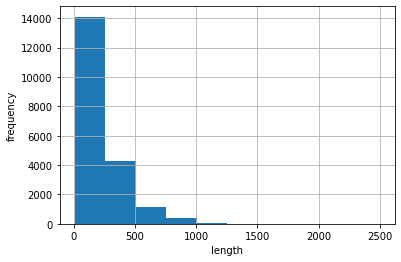

In [82]:
import matplotlib.pyplot as plt 
lengths = np.array([len(x) for x in x_train])  # train set의 sequence의 길이들을 모음 
print("훈련 데이터 셋 길이의 평균   : ", np.mean(lengths))
print("훈련 데이터 셋 길이의 중간값 : ", np.median(lengths))

plt.hist(lengths)
plt.grid()
plt.xlabel("length")
plt.ylabel("frequency")

### 2. 샘플 길이 맞추고 원-핫 인코딩하기

![figure1](https://github.com/music-ai-644/AI_Study_2022/blob/main/figure/Chapter9_1.PNG?raw=true)
- 순환 신경망의 경우, sequence의 길이가 짧은 경우, 뒤에 하는 것이 아니라 앞에 함
- 텍스트 분류를 위해서 신경망의 가장 마지막 output을 사용하게 되는데, 이 때 뒤에 패딩한 값(zero 혹은 기타)이 영향을 주게 되어 실제 데이터와 무관한 값이 나올 수 있음

![figure2](https://github.com/music-ai-644/AI_Study_2022/blob/main/figure/Chapter9_2.PNG?raw=true)

In [83]:
from tensorflow.keras.preprocessing import sequence 

maxlen = 100  # 배치 내의 sequence의 길이를 최대 100으로 함 
x_train_seq = sequence.pad_sequences(x_train, maxlen=maxlen)
x_valid_seq = sequence.pad_sequences(x_valid, maxlen=maxlen)
x_test_seq = sequence.pad_sequences(x_test, maxlen=maxlen)

![figure5](https://github.com/music-ai-644/AI_Study_2022/blob/main/figure/Chapter9_5.PNG?raw=true)

In [84]:
print("훈련 데이터 셋의 형태 : ", np.shape(x_train_seq))

훈련 데이터 셋의 형태 :  (20000, 100)


In [85]:
print("훈련 데이터 셋의 타겟 : ", np.shape(x_train_seq))  # (전체 샘플 개수, sequence 길이, 단어의 개수)
print("평가 데이터 셋의 타겟 : ", np.shape(x_valid_seq))  # (전체 샘플 개수, sequence 길이, 단어의 개수)

훈련 데이터 셋의 타겟 :  (20000, 100)
평가 데이터 셋의 타겟 :  (5000, 100)


In [86]:
import torch
x_train_torch = torch.FloatTensor(x_train_seq)
y_train_torch = torch.FloatTensor(y_train)
x_valid_torch = torch.FloatTensor(x_valid_seq)
y_valid_torch = torch.FloatTensor(y_valid) 
x_test_torch = torch.FloatTensor(x_test_seq)
y_test_torch = torch.FloatTensor(y_test) 

In [87]:
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader 

In [88]:
class IMDBDataset(Dataset):
  def __init__(self, x, y):
    self.x_data = x 
    self.y_data = y 

  def __getitem__(self, index):
    x = self.x_data[index]
    y = self.y_data[index]
    return x, y

  def collate_fn(self, batch):
    x, y = zip(*batch)
    return x, y 

  def __len__(self):
    return len(self.x_data)


In [89]:
dataset = IMDBDataset(x_train_torch, y_train_torch)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, drop_last=True)

![figure6](https://github.com/music-ai-644/AI_Study_2022/blob/main/figure/Chapter9_6.PNG?raw=true)

In [101]:
class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()
    self.n_layer = 1
    self.n_hidden = 100
    self.embedding = nn.Embedding(200, self.n_hidden)
    self.rnn = nn.RNN(self.n_hidden, self.n_hidden)
    self.linear = nn.Linear(self.n_hidden, 1)
    self.sigmoid = nn.Sigmoid()
  
  def forward(self, x):
    x = self.embedding(x)
    output, hidden = self.rnn(x)
    predicts = self.linear(output[-1, :, :])
    predicts = self.sigmoid(predicts)
    return predicts

  def predict(self, x):
    predicts = []
    len_x = x.size(1)
    for i in range(len_x):
      pred = model(x[:, i].unsqueeze(1))
      predicts.append(pred.data.numpy()[0])
    return np.array(predicts) > 0.5

In [ ]:
from tqdm import tqdm 
import random 

random_seed = 123
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)

model = MyModel() 
model.train()

optim = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCELoss()

global_step = 0 
for epoch in range(10):
  t = tqdm(dataloader, ncols=100)
  for i, batch in enumerate(t):
    x_batch = batch[0]
    y_batch = batch[1]
    x_batch = x_batch.transpose(0, 1)
    model.zero_grad()
    predicts = model(x_batch.long())
    loss = criterion(predicts[:,0], y_batch)
    loss.backward()
    optim.step()

    global_step += 1
    t.set_description("epoch: {} | global_step: {:8d} | loss: {:.4f}".format(epoch + 1, global_step, loss))
  
  with torch.no_grad():
    model.eval()
    predicts = model.predict(x_valid_torch.transpose(0, 1).long())
    result = np.mean(predicts == y_test)
    print("정확도 : {:%}".format(result))
    model.train()

epoch: 1 | global_step:      378 | loss: 0.6771:  30%|███▎       | 378/1250 [00:59<02:05,  6.93it/s]

In [ ]:
result = np.mean(predicts(x_test_torch) == y_test)
print("epoch: {} | global_step: {} | valid acc: {:%}".format(epoch + 1, global_step, acc))